<a href="https://colab.research.google.com/github/IMOKURI/wandb-demo/blob/main/WandB_Baseline_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📔 About this notebook

Image classification baseline.

## 📝 Memo

# Check Environment

In [ ]:
!free -m

In [ ]:
!python --version

In [ ]:
!nvidia-smi

In [ ]:
!nvcc --version

# Prepare for Kaggle

- Add dataset [imokuri/wandbtoken](https://www.kaggle.com/imokuri/wandbtoken)

# Prepare for Colab

In [ ]:
import os
import sys
import zipfile

if os.path.exists('init.txt'):
    print("Already initialized.")

else:
    if 'google.colab' in sys.modules:
        from google.colab import drive
        drive.mount('/content/drive')
        dataset_dir = "/content/drive/MyDrive/Datasets"

        # ====================================================
        # Competition datasets
        # ====================================================
        with zipfile.ZipFile(f"{dataset_dir}/cassava-leaf-disease-classification-2021.zip", "r") as zp:
            zp.extractall(path="./")

    # for StratifiedGroupKFold
    # !pip install -q -U scikit-learn

    # for MultilabelStratifiedKFold
    # !pip install -q iterative-stratification

    # for CosineAnnealingWarmupRestarts
    # !pip install -qU 'git+https://github.com/katsura-jp/pytorch-cosine-annealing-with-warmup'

    !pip install -q wandb
    # !pip install -q optuna

    # ====================================================
    # Competition specific libraries
    # ====================================================
    !pip install -q timm
    !pip install -q albumentations==0.4.6

    !touch init.txt

Already initialized.


# 📚 Library

In [ ]:
# General libraries
import collections
import glob
import json
import math
import os
import random
import re
import statistics
import time
import warnings
from contextlib import contextmanager

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import torch
import torch.cuda.amp as amp
import torch.nn as nn
import torch.nn.functional as F
import wandb
# from cosine_annealing_warmup import CosineAnnealingWarmupRestarts
# from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold  # , StratifiedGroupKFold
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

In [ ]:
# Competition specific libraries
import albumentations as A
import cv2
import timm
from albumentations.pytorch import ToTensorV2

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
netrc = "/content/drive/MyDrive/.netrc" if 'google.colab' in sys.modules else "../input/wandbtoken/.netrc"
!cp -f {netrc} ~/
!wandb login

wandb_tags = []

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    wandb_tags.append(torch.cuda.get_device_name(0))

# Load Data

In [ ]:
DATA_DIR = "./" if 'google.colab' in sys.modules else "../input/xxx/"
OUTPUT_DIR = "./"
MODEL_DIR = "./models/"

!rm -rf {MODEL_DIR}

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

In [ ]:
train = pd.read_csv(DATA_DIR + "train.csv")
# test = pd.read_csv(DATA_DIR + "test.csv")
sub = pd.read_csv(DATA_DIR + "sample_submission.csv")

TRAIN_IMAGE_PATH = DATA_DIR + "train_images/"
TEST_IMAGE_PATH = DATA_DIR + "test_images/"

# 🤔 Config

In [ ]:
# seed = random.randrange(10000)
seed = 440
print(seed)

440


In [ ]:
class Config:
    wandb_entity = "imokuri"
    wandb_project = "baseline"
    print_freq = 100

    train = True
    validate = False
    inference = False

    debug = False
    num_debug_data = 1000

    amp = True

In [ ]:
config_defaults = {
    "seed": seed,
    "n_class": 5,
    "n_fold": 5,
    "epochs": 10,
    "batch_size": 32,
    "gradient_accumulation_steps": 1,
    "max_grad_norm": 1000,
    "criterion": "CrossEntropyLoss",
    "optimizer": "Adam",
    "scheduler": "CosineAnnealingWarmRestarts",
    "lr": 1e-4,
    "min_lr": 5e-6,
    "weight_decay": 1e-6,
    "model_name": "resnext50_32x4d", # "vit_base_patch16_384", "tf_efficientnetv2_m_in21k",
    "size": 512,
}

In [ ]:
if Config.debug:
    config_defaults["n_fold"] = 3
    config_defaults["epochs"] = 1
    Config.print_freq = 10

In [ ]:
if Config.train:
    wandb_job_type = "training"

elif Config.inference:
    wandb_job_type = "inference"

elif Config.validate:
    wandb_job_type = "validation"

else:
    wandb_job_type = ""

In [ ]:
if Config.debug:
    wandb_tags.append("debug")
    
if Config.amp:
    wandb_tags.append("amp")

In [ ]:
if Config.debug:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        tags=wandb_tags,
        mode="disabled",
    )
else:
    run = wandb.init(
        entity=Config.wandb_entity,
        project=Config.wandb_project,
        config=config_defaults,
        job_type=wandb_job_type,
        tags=wandb_tags,
        save_code=True,
    )

wandb: Currently logged in as: imokuri (use `wandb login --relogin` to force relogin)


In [ ]:
config = wandb.config

# EDA 1

In [ ]:
# for df in [train, test, sub]:
for df in [train, sub]:
    print(f"=" * 120)
    df.info()
    display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  1 non-null      object
 1   label     1 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 144.0+ bytes


,image_id,label
0,2216849948.jpg,4


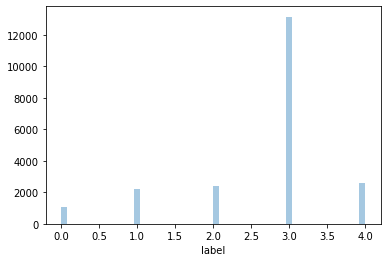

In [ ]:
sns.distplot(train["label"], kde=False)

# Preprocess

In [ ]:
def get_transforms(*, data):
    if data == "train":
        return A.Compose(
            [
                # A.Resize(config.size, config.size),
                A.RandomResizedCrop(config.size, config.size),
                A.Transpose(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ShiftScaleRotate(p=0.5),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return A.Compose(
            [
                A.Resize(config.size, config.size),
                A.CenterCrop(config.size, config.size),
                A.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

# EDA 2

# 👑 Load Artifacts

In [ ]:
if Config.debug:
    train = train.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
    if len(sub) > Config.num_debug_data:
        # test = test.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)
        sub = sub.sample(n=Config.num_debug_data, random_state=config.seed).reset_index(drop=True)

# Utils

In [ ]:
@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=config.seed)

# Make Fold

In [ ]:
Fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train["label"])):
    train.loc[val_index, "fold"] = int(n)
train["fold"] = train["fold"].astype(np.int8)
print(train.groupby(["fold", "label"]).size())

fold  label
0     0         218
      1         438
      2         477
      3        2631
      4         516
1     0         218
      1         438
      2         477
      3        2631
      4         516
2     0         217
      1         438
      2         477
      3        2632
      4         515
3     0         217
      1         438
      2         477
      3        2632
      4         515
4     0         217
      1         437
      2         478
      3        2632
      4         515
dtype: int64


# Dataset

In [ ]:
class BaseDataset(Dataset):
    def __init__(self, df, transform=None, label=True):
        self.df = df
        self.file_names = df["image_id"].values
        self.transform = transform

        self.use_label = label
        if self.use_label:
            self.path = TRAIN_IMAGE_PATH
            self.labels = df["label"].values
        else:
            self.path = TEST_IMAGE_PATH

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{self.path}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        if self.use_label:
            label = torch.tensor(self.labels[idx])
            return image, label
        return image

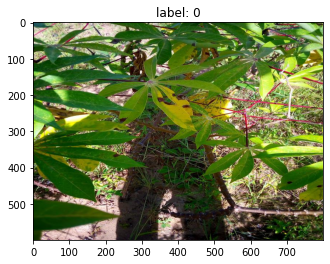

In [ ]:
train_ds = BaseDataset(train)
image, label = train_ds[0]
plt.imshow(image)
plt.title(f"label: {label}")
plt.show()

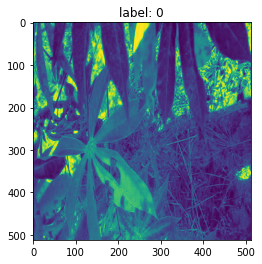

In [ ]:
train_ds = BaseDataset(train, transform=get_transforms(data="train"))
image, label = train_ds[0]
plt.imshow(image[0])
plt.title(f"label: {label}")
plt.show()

# 🚗 Model

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super().__init__()
        self.model_name = model_name
        self.model = timm.create_model(model_name, pretrained=pretrained)

        if "resnext50_32x4d" in model_name:
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, config.n_class)

        elif model_name.startswith("tf_efficientnet"):
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, config.n_class)

        elif model_name.startswith("vit_"):
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, config.n_class)

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
if config.model_name != "":
    model = BaseModel(config.model_name)
    print(model)

    train_ds = BaseDataset(train, transform=get_transforms(data="train"))
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

    for image, label in train_loader:
        output = model(image)
        print(output)
        break

BaseModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

# Optimizer

# Loss

# Scoring

In [ ]:
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

In [ ]:
def get_result(result_df, fold=config.n_fold):
    preds = result_df["preds"].values
    labels = result_df["label"].values
    score = get_score(labels, preds)
    LOGGER.info(f"Score: {score:<.5f}")
    if fold == config.n_fold:
        wandb.log({"CV": score})
    else:
        wandb.log({f"CV_fold{fold}": score})

# Helper functions

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

In [ ]:
def compute_grad_norm(parameters, norm_type=2.0):
    """Refer to torch.nn.utils.clip_grad_norm_"""
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    parameters = [p for p in parameters if p.grad is not None]
    norm_type = float(norm_type)
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type
    total_norm = total_norm ** (1. / norm_type)
    return total_norm

In [ ]:
def train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device):
    losses = AverageMeter()

    # switch to train mode
    model.train()
    start = time.time()
    optimizer.zero_grad()

    for step, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with amp.autocast(enabled=Config.amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            losses.update(loss.item(), batch_size)
            loss = loss / config.gradient_accumulation_steps
            
        scaler.scale(loss).backward()

        if (step + 1) % config.gradient_accumulation_steps == 0:
            scaler.unscale_(optimizer)
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
            scaler.step(optimizer)
            scaler.update()

            scheduler.step()
            optimizer.zero_grad()
        else:
            grad_norm = compute_grad_norm(model.parameters())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                f"Epoch: [{epoch + 1}][{step}/{len(train_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(train_loader)):s} "
                f"Loss: {losses.avg:.4f} "
                f"Grad: {grad_norm:.4f} "
                f"LR: {scheduler.get_lr()[0]:.6f}  "
            )

    return losses.avg

In [ ]:
def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = time.time()

    for step, (images, labels) in enumerate(valid_loader):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)

        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        preds.append(y_preds.softmax(1).to("cpu").numpy())
        # preds.append(y_preds.to("cpu").numpy())

        end = time.time()
        if step % Config.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                f"EVAL: [{step}/{len(valid_loader)}] "
                f"Elapsed {timeSince(start, float(step + 1) / len(valid_loader)):s} "
                f"Loss: {losses.avg:.4f} "
            )

    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Postprocess

# 🏃‍♂️ Train loop

In [ ]:
def train_loop(df, fold):
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # Data Loader
    # ====================================================
    trn_idx = df[df["fold"] != fold].index
    val_idx = df[df["fold"] == fold].index

    train_folds = df.loc[trn_idx].reset_index(drop=True)
    valid_folds = df.loc[val_idx].reset_index(drop=True)

    train_dataset = BaseDataset(train_folds, transform=get_transforms(data="train"))
    valid_dataset = BaseDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # Optimizer
    # ====================================================
    def get_optimizer(model):
        if config.optimizer == "Adam":
            optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        elif config.optimizer == "AdamW":
            optimizer = T.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        return optimizer

    # ====================================================
    # Scheduler
    # ====================================================
    def get_scheduler(optimizer, train_folds):
        num_data = len(train_folds)
        num_steps = num_data // (config.batch_size * config.gradient_accumulation_steps) * config.epochs

        if config.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=num_steps, T_mult=1, eta_min=config.min_lr, last_epoch=-1)
        elif config.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=num_steps, eta_min=config.min_lr, last_epoch=-1)
        elif config.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer, first_cycle_steps=num_steps, max_lr=config.lr, min_lr=config.min_lr, warmup_steps=(num_steps // 10)
            )
        return scheduler

    # ====================================================
    # Model
    # ====================================================
    model = BaseModel(config.model_name)
    model.to(device)

    optimizer = get_optimizer(model)
    scaler = amp.GradScaler(enabled=Config.amp)
    scheduler = get_scheduler(optimizer, train_folds)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if config.criterion == "CrossEntropyLoss":
            criterion = nn.CrossEntropyLoss()
        elif config.criterion == "BCEWithLogitsLoss":
            criterion = nn.BCEWithLogitsLoss()
        elif config.criterion == "MSELoss":
            criterion = nn.MSELoss()
        return criterion

    criterion = get_criterion()

    # ====================================================
    # Loop
    # ====================================================
    best_score = -1
    best_loss = np.inf
    best_preds = None

    for epoch in range(config.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, scheduler, scaler, epoch, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds["label"].values

        # if config.criterion == "BCEWithLogitsLoss":
        #     preds = 1 / (1 + np.exp(-preds))

        # scoring
        score = get_score(valid_labels, preds.argmax(1))
        # score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time
        LOGGER.info(f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s")
        LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

        wandb.log({
            "epoch": epoch + 1,
            f"loss/train_fold{fold}": avg_loss,
            f"loss/valid_fold{fold}": avg_val_loss,
            f"score/fold{fold}": score,
        })

        if avg_val_loss < best_loss:
            best_score = score
            best_loss = avg_val_loss
            best_preds = preds
            LOGGER.info(f"Epoch {epoch+1} - Save Best Model. score: {best_score:.4f}, loss: {best_loss:.4f}")

            torch.save(
                {"model": model.state_dict(), "preds": preds}, MODEL_DIR + f"{config.model_name.replace('/', '-')}_fold{fold}_best.pth"
            )
            # use artifacts instead
            # wandb.save(MODEL_DIR + f"{config.model_name.replace('/', '-')}_fold{fold}_best.pth")

    valid_folds[[str(c) for c in range(config.n_class)]] = best_preds
    valid_folds["preds"] = best_preds.argmax(1)
    # valid_folds["preds"] = best_preds

    return valid_folds, best_score, best_loss

# Main function

In [ ]:
def main():
    # ====================================================
    # Training
    # ====================================================
    if Config.train:
        oof_df = pd.DataFrame()
        oof_result = []
        for fold in range(config.n_fold):
            seed_torch(seed + fold)

            _oof_df, score, loss = train_loop(train, fold)
            oof_df = pd.concat([oof_df, _oof_df])
            oof_result.append([fold, score, loss])
            
            LOGGER.info(f"========== fold: {fold} result ==========")
            get_result(_oof_df, fold)
            
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)

        loss = statistics.mean([d[2] for d in oof_result])
        wandb.log({"loss": loss})

        table = wandb.Table(data=oof_result, columns = ["fold", "score", "loss"])
        run.log({"Fold Result": table})
        
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)
        wandb.save(OUTPUT_DIR + "oof_df.csv")

        artifact = wandb.Artifact(config.model_name, type='model')
        artifact.add_dir(MODEL_DIR)
        run.log_artifact(artifact)


# 🚀 Run

In [ ]:
main()

========== fold: 0 training ==========


Epoch: [1][0/534] Elapsed 0m 3s (remain 35m 18s) Loss: 1.6243 Grad: 6.8709 LR: 0.000100  
Epoch: [1][100/534] Elapsed 1m 51s (remain 7m 56s) Loss: 0.7697 Grad: 5.3519 LR: 0.000100  
Epoch: [1][200/534] Elapsed 3m 37s (remain 6m 0s) Loss: 0.6626 Grad: 7.0452 LR: 0.000100  
Epoch: [1][300/534] Elapsed 5m 24s (remain 4m 11s) Loss: 0.6175 Grad: 7.2638 LR: 0.000099  
Epoch: [1][400/534] Elapsed 7m 11s (remain 2m 23s) Loss: 0.5905 Grad: 5.5678 LR: 0.000099  
Epoch: [1][500/534] Elapsed 8m 57s (remain 0m 35s) Loss: 0.5715 Grad: 3.6822 LR: 0.000098  
Epoch: [1][533/534] Elapsed 9m 33s (remain 0m 0s) Loss: 0.5693 Grad: 4.8830 LR: 0.000098  
EVAL: [0/134] Elapsed 0m 2s (remain 5m 41s) Loss: 0.4206 
EVAL: [100/134] Elapsed 0m 48s (remain 0m 15s) Loss: 0.4449 


Epoch 1 - avg_train_loss: 0.5693  avg_val_loss: 0.4239  time: 636s
Epoch 1 - Score: 0.8549065420560747
Epoch 1 - Save Best Model. score: 0.8549, loss: 0.4239


EVAL: [133/134] Elapsed 1m 2s (remain 0m 0s) Loss: 0.4239 
Epoch: [2][0/534] Elapsed 0m 3s (remain 31m 7s) Loss: 0.2993 Grad: 2.9537 LR: 0.000098  
Epoch: [2][100/534] Elapsed 1m 50s (remain 7m 53s) Loss: 0.4616 Grad: 4.9105 LR: 0.000097  
Epoch: [2][200/534] Elapsed 3m 37s (remain 5m 59s) Loss: 0.4588 Grad: 5.1401 LR: 0.000096  
Epoch: [2][300/534] Elapsed 5m 23s (remain 4m 10s) Loss: 0.4642 Grad: 4.0810 LR: 0.000094  
Epoch: [2][400/534] Elapsed 7m 10s (remain 2m 22s) Loss: 0.4603 Grad: 3.1476 LR: 0.000093  
Epoch: [2][500/534] Elapsed 8m 57s (remain 0m 35s) Loss: 0.4538 Grad: 3.6877 LR: 0.000091  
Epoch: [2][533/534] Elapsed 9m 32s (remain 0m 0s) Loss: 0.4533 Grad: 3.6868 LR: 0.000091  
EVAL: [0/134] Elapsed 0m 1s (remain 4m 24s) Loss: 0.3854 
EVAL: [100/134] Elapsed 0m 47s (remain 0m 15s) Loss: 0.4018 


Epoch 2 - avg_train_loss: 0.4533  avg_val_loss: 0.3817  time: 635s
Epoch 2 - Score: 0.872196261682243
Epoch 2 - Save Best Model. score: 0.8722, loss: 0.3817


EVAL: [133/134] Elapsed 1m 2s (remain 0m 0s) Loss: 0.3817 
Epoch: [3][0/534] Elapsed 0m 2s (remain 26m 9s) Loss: 0.5130 Grad: 5.0588 LR: 0.000091  
Epoch: [3][100/534] Elapsed 1m 49s (remain 7m 50s) Loss: 0.4516 Grad: 3.3466 LR: 0.000089  
Epoch: [3][200/534] Elapsed 3m 36s (remain 5m 58s) Loss: 0.4506 Grad: 4.0922 LR: 0.000087  
Epoch: [3][300/534] Elapsed 5m 23s (remain 4m 10s) Loss: 0.4316 Grad: 3.2803 LR: 0.000085  
Epoch: [3][400/534] Elapsed 7m 9s (remain 2m 22s) Loss: 0.4301 Grad: 3.9264 LR: 0.000083  
Epoch: [3][500/534] Elapsed 8m 56s (remain 0m 35s) Loss: 0.4248 Grad: 3.4844 LR: 0.000081  
Epoch: [3][533/534] Elapsed 9m 31s (remain 0m 0s) Loss: 0.4240 Grad: 3.2046 LR: 0.000080  
EVAL: [0/134] Elapsed 0m 2s (remain 5m 45s) Loss: 0.3496 
EVAL: [100/134] Elapsed 0m 47s (remain 0m 15s) Loss: 0.3760 


Epoch 3 - avg_train_loss: 0.4240  avg_val_loss: 0.3627  time: 634s
Epoch 3 - Score: 0.8789719626168224
Epoch 3 - Save Best Model. score: 0.8790, loss: 0.3627


EVAL: [133/134] Elapsed 1m 2s (remain 0m 0s) Loss: 0.3627 
Epoch: [4][0/534] Elapsed 0m 3s (remain 28m 58s) Loss: 0.4952 Grad: 3.8659 LR: 0.000080  
Epoch: [4][100/534] Elapsed 1m 50s (remain 7m 51s) Loss: 0.3831 Grad: 2.7343 LR: 0.000078  
Epoch: [4][200/534] Elapsed 3m 36s (remain 5m 59s) Loss: 0.3960 Grad: 3.9636 LR: 0.000076  
Epoch: [4][300/534] Elapsed 5m 23s (remain 4m 10s) Loss: 0.3827 Grad: 3.4316 LR: 0.000073  
Epoch: [4][400/534] Elapsed 7m 10s (remain 2m 22s) Loss: 0.3860 Grad: 3.6893 LR: 0.000071  
Epoch: [4][500/534] Elapsed 8m 56s (remain 0m 35s) Loss: 0.3921 Grad: 2.7943 LR: 0.000068  
Epoch: [4][533/534] Elapsed 9m 31s (remain 0m 0s) Loss: 0.3956 Grad: 3.7796 LR: 0.000067  
EVAL: [0/134] Elapsed 0m 2s (remain 4m 56s) Loss: 0.3951 
EVAL: [100/134] Elapsed 0m 47s (remain 0m 15s) Loss: 0.3473 


Epoch 4 - avg_train_loss: 0.3956  avg_val_loss: 0.3350  time: 634s
Epoch 4 - Score: 0.8869158878504673
Epoch 4 - Save Best Model. score: 0.8869, loss: 0.3350


EVAL: [133/134] Elapsed 1m 2s (remain 0m 0s) Loss: 0.3350 
Epoch: [5][0/534] Elapsed 0m 3s (remain 30m 56s) Loss: 0.3139 Grad: 3.3793 LR: 0.000067  
Epoch: [5][100/534] Elapsed 1m 50s (remain 7m 52s) Loss: 0.3557 Grad: 4.0577 LR: 0.000064  
Epoch: [5][200/534] Elapsed 3m 36s (remain 5m 59s) Loss: 0.3700 Grad: 3.1795 LR: 0.000062  
Epoch: [5][300/534] Elapsed 5m 23s (remain 4m 10s) Loss: 0.3656 Grad: 5.4371 LR: 0.000059  
Epoch: [5][400/534] Elapsed 7m 10s (remain 2m 22s) Loss: 0.3666 Grad: 4.3897 LR: 0.000056  
Epoch: [5][500/534] Elapsed 8m 57s (remain 0m 35s) Loss: 0.3672 Grad: 3.6531 LR: 0.000053  
Epoch: [5][533/534] Elapsed 9m 32s (remain 0m 0s) Loss: 0.3716 Grad: 4.1848 LR: 0.000053  
EVAL: [0/134] Elapsed 0m 2s (remain 5m 37s) Loss: 0.3654 
EVAL: [100/134] Elapsed 0m 47s (remain 0m 15s) Loss: 0.3512 


Epoch 5 - avg_train_loss: 0.3716  avg_val_loss: 0.3373  time: 634s
Epoch 5 - Score: 0.888785046728972


EVAL: [133/134] Elapsed 1m 1s (remain 0m 0s) Loss: 0.3373 
Epoch: [6][0/534] Elapsed 0m 3s (remain 27m 48s) Loss: 0.3698 Grad: 3.5497 LR: 0.000052  
Epoch: [6][100/534] Elapsed 1m 50s (remain 7m 51s) Loss: 0.3444 Grad: 3.0547 LR: 0.000050  
Epoch: [6][200/534] Elapsed 3m 36s (remain 5m 58s) Loss: 0.3488 Grad: 4.0169 LR: 0.000047  
Epoch: [6][300/534] Elapsed 5m 23s (remain 4m 10s) Loss: 0.3474 Grad: 4.0960 LR: 0.000044  
Epoch: [6][400/534] Elapsed 7m 10s (remain 2m 22s) Loss: 0.3498 Grad: 2.8950 LR: 0.000041  
Epoch: [6][500/534] Elapsed 8m 56s (remain 0m 35s) Loss: 0.3503 Grad: 2.8810 LR: 0.000039  
Epoch: [6][533/534] Elapsed 9m 31s (remain 0m 0s) Loss: 0.3491 Grad: 4.8491 LR: 0.000038  
EVAL: [0/134] Elapsed 0m 2s (remain 4m 46s) Loss: 0.3355 
EVAL: [100/134] Elapsed 0m 47s (remain 0m 15s) Loss: 0.3458 


Epoch 6 - avg_train_loss: 0.3491  avg_val_loss: 0.3310  time: 634s
Epoch 6 - Score: 0.8908878504672897
Epoch 6 - Save Best Model. score: 0.8909, loss: 0.3310


EVAL: [133/134] Elapsed 1m 1s (remain 0m 0s) Loss: 0.3310 
Epoch: [7][0/534] Elapsed 0m 3s (remain 30m 32s) Loss: 0.3514 Grad: 4.3338 LR: 0.000038  
Epoch: [7][100/534] Elapsed 1m 50s (remain 7m 53s) Loss: 0.3401 Grad: 1.6894 LR: 0.000035  
Epoch: [7][200/534] Elapsed 3m 37s (remain 5m 59s) Loss: 0.3367 Grad: 3.7368 LR: 0.000033  
Epoch: [7][300/534] Elapsed 5m 23s (remain 4m 10s) Loss: 0.3357 Grad: 3.2425 LR: 0.000030  
Epoch: [7][400/534] Elapsed 7m 10s (remain 2m 22s) Loss: 0.3335 Grad: 2.4364 LR: 0.000028  
Epoch: [7][500/534] Elapsed 8m 57s (remain 0m 35s) Loss: 0.3306 Grad: 5.9629 LR: 0.000025  
Epoch: [7][533/534] Elapsed 9m 32s (remain 0m 0s) Loss: 0.3328 Grad: 4.3666 LR: 0.000025  
EVAL: [0/134] Elapsed 0m 2s (remain 5m 2s) Loss: 0.2947 
EVAL: [100/134] Elapsed 0m 47s (remain 0m 15s) Loss: 0.3432 


Epoch 7 - avg_train_loss: 0.3328  avg_val_loss: 0.3276  time: 634s
Epoch 7 - Score: 0.8920560747663552
Epoch 7 - Save Best Model. score: 0.8921, loss: 0.3276


EVAL: [133/134] Elapsed 1m 1s (remain 0m 0s) Loss: 0.3276 
Epoch: [8][0/534] Elapsed 0m 3s (remain 32m 32s) Loss: 0.3697 Grad: 3.8455 LR: 0.000025  
Epoch: [8][100/534] Elapsed 1m 50s (remain 7m 53s) Loss: 0.3097 Grad: 4.0152 LR: 0.000022  
Epoch: [8][200/534] Elapsed 3m 37s (remain 5m 59s) Loss: 0.3136 Grad: 3.3266 LR: 0.000020  
Epoch: [8][300/534] Elapsed 5m 23s (remain 4m 10s) Loss: 0.3117 Grad: 4.5339 LR: 0.000018  
Epoch: [8][400/534] Elapsed 7m 10s (remain 2m 22s) Loss: 0.3110 Grad: 3.4400 LR: 0.000016  
Epoch: [8][500/534] Elapsed 8m 57s (remain 0m 35s) Loss: 0.3098 Grad: 3.6213 LR: 0.000015  
Epoch: [8][533/534] Elapsed 9m 32s (remain 0m 0s) Loss: 0.3118 Grad: 3.4410 LR: 0.000014  
EVAL: [0/134] Elapsed 0m 2s (remain 4m 37s) Loss: 0.3670 
EVAL: [100/134] Elapsed 0m 47s (remain 0m 15s) Loss: 0.3339 


Epoch 8 - avg_train_loss: 0.3118  avg_val_loss: 0.3215  time: 634s
Epoch 8 - Score: 0.8929906542056075
Epoch 8 - Save Best Model. score: 0.8930, loss: 0.3215


EVAL: [133/134] Elapsed 1m 1s (remain 0m 0s) Loss: 0.3215 
Epoch: [9][0/534] Elapsed 0m 3s (remain 29m 34s) Loss: 0.5203 Grad: 5.5749 LR: 0.000014  
Epoch: [9][100/534] Elapsed 1m 50s (remain 7m 52s) Loss: 0.2909 Grad: 3.6733 LR: 0.000012  
Epoch: [9][200/534] Elapsed 3m 36s (remain 5m 59s) Loss: 0.3045 Grad: 4.3526 LR: 0.000011  
Epoch: [9][300/534] Elapsed 5m 23s (remain 4m 10s) Loss: 0.3018 Grad: 3.0899 LR: 0.000010  
Epoch: [9][400/534] Elapsed 7m 10s (remain 2m 22s) Loss: 0.2993 Grad: 2.7660 LR: 0.000009  
Epoch: [9][500/534] Elapsed 8m 56s (remain 0m 35s) Loss: 0.2974 Grad: 4.5001 LR: 0.000008  
Epoch: [9][533/534] Elapsed 9m 32s (remain 0m 0s) Loss: 0.2969 Grad: 2.7521 LR: 0.000007  
EVAL: [0/134] Elapsed 0m 2s (remain 5m 27s) Loss: 0.3180 
EVAL: [100/134] Elapsed 0m 47s (remain 0m 15s) Loss: 0.3370 


Epoch 9 - avg_train_loss: 0.2969  avg_val_loss: 0.3226  time: 634s
Epoch 9 - Score: 0.8946261682242991


EVAL: [133/134] Elapsed 1m 1s (remain 0m 0s) Loss: 0.3226 
Epoch: [10][0/534] Elapsed 0m 3s (remain 28m 31s) Loss: 0.1661 Grad: 3.4667 LR: 0.000007  
Epoch: [10][100/534] Elapsed 1m 49s (remain 7m 51s) Loss: 0.2649 Grad: 3.1449 LR: 0.000007  
Epoch: [10][200/534] Elapsed 3m 36s (remain 5m 59s) Loss: 0.2718 Grad: 4.0256 LR: 0.000006  
Epoch: [10][300/534] Elapsed 5m 23s (remain 4m 10s) Loss: 0.2689 Grad: 4.9188 LR: 0.000005  
Epoch: [10][400/534] Elapsed 7m 10s (remain 2m 22s) Loss: 0.2756 Grad: 6.6223 LR: 0.000005  
Epoch: [10][500/534] Elapsed 8m 56s (remain 0m 35s) Loss: 0.2788 Grad: 5.5998 LR: 0.000005  
Epoch: [10][533/534] Elapsed 9m 31s (remain 0m 0s) Loss: 0.2785 Grad: 3.7180 LR: 0.000100  
EVAL: [0/134] Elapsed 0m 2s (remain 4m 30s) Loss: 0.3214 
EVAL: [100/134] Elapsed 0m 47s (remain 0m 15s) Loss: 0.3370 


Epoch 10 - avg_train_loss: 0.2785  avg_val_loss: 0.3230  time: 634s
Epoch 10 - Score: 0.8957943925233645
========== fold: 0 result ==========
Score: 0.89299
========== fold: 1 training ==========


EVAL: [133/134] Elapsed 1m 1s (remain 0m 0s) Loss: 0.3230 
Epoch: [1][0/534] Elapsed 0m 3s (remain 32m 45s) Loss: 1.6335 Grad: 6.2844 LR: 0.000100  


KeyboardInterrupt: ignored

In [ ]:
wandb.finish()